As per the Mr. Umair Shahzad this assignment is to learn that how the images can be converted to tensors and the accuracy is not that important. If Convolution, Image Augumentation and Transfer learning is used, then accuracy can be achived above 80%. But without all this stuff, accuracy is not good. So please don't reject this assignment. It took me 3 weeks to complete this assignment since initially I lost so much time to attain 85% accuracy by using convolution and Transfer learning. Thanks 

In [1]:
import os
import zipfile
import numpy as np
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.preprocessing import image
import tensorflow as tf
from google.colab import files
from keras import models
from keras import layers
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
local_zip = "/content/drive/MyDrive/flowers_new.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/flower_new")
zip_ref.close()

**Converting the images to gray scale tensor and resize**

In [4]:
pic_size = 50
def convert_image(source, label):
  fname = os.listdir(source)
  images= None
  
  for i,value in enumerate(fname):
    source_path = os.path.join(source, fname[i])
    if os.path.getsize(source_path)==0:
      print("file has zero size")
    else:
      img=image.load_img(source_path, target_size=(pic_size, pic_size)) # Load image
      x=image.img_to_array(img)                               # Image to array RGB
      x=tf.image.rgb_to_grayscale(x)                          # gray scale conversion
      x=np.expand_dims(x, axis=0)
      if images is None:
        images = x
      else:
        images = np.vstack((images, x))
  print(images.shape)
  images=images.reshape(images.shape[0], pic_size*pic_size*1)
  print(images.shape)
  label_in = np.ones((len(fname), 1))
  label_in.fill(label)
  print(label_in.shape)
  images_new=np.hstack((images,label_in))
  print(images_new.shape)
  return images_new


In [6]:
daisy_source_dir = "/flower_new/flowers/daisy"

dandelion_source_dir = "/flower_new/flowers/dandelion"

rose_source_dir = "/flower_new/flowers/rose"

sunflower_source_dir = "/flower_new/flowers/sunflower"

tulip_source_dir = "/flower_new/flowers/tulip"

**Converting the Images into tensor**

In [7]:
daisy = convert_image(daisy_source_dir, 0)
dandelion = convert_image(dandelion_source_dir, 1)
rose = convert_image(rose_source_dir, 2)
sunflower = convert_image(sunflower_source_dir, 3)
tulip = convert_image(tulip_source_dir, 4)

(769, 50, 50, 1)
(769, 2500)
(769, 1)
(769, 2501)
(1052, 50, 50, 1)
(1052, 2500)
(1052, 1)
(1052, 2501)
(784, 50, 50, 1)
(784, 2500)
(784, 1)
(784, 2501)
(734, 50, 50, 1)
(734, 2500)
(734, 1)
(734, 2501)
(984, 50, 50, 1)
(984, 2500)
(984, 1)
(984, 2501)


In [8]:
data_array = np.vstack((daisy, dandelion, rose, sunflower, tulip))
data_array.shape


(4323, 2501)

In [9]:
import pandas as pd
df = pd.DataFrame(data_array)

In [10]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,88.601402,76.363800,26.770901,34.884102,90.681198,152.131104,160.130295,166.912415,179.754013,184.981506,182.981705,184.981506,184.981506,184.269699,178.911209,188.138306,176.655609,152.658005,55.811104,16.896700,14.896900,15.1249,18.885702,39.248901,46.248203,40.117802,22.113401,14.108001,9.706300,14.064900,15.608700,15.608700,12.749100,15.976801,18.261801,17.962900,24.962200,145.022308,53.877102,10.353400,...,15.772000,14.772100,24.141001,27.847900,33.109398,22.848400,14.7721,10.011400,15.131101,31.368301,149.213104,146.914398,12.125200,12.125200,12.125200,11.837100,18.141600,23.913002,18.831800,19.130701,26.136202,23.158100,27.869499,38.917698,33.978302,30.847601,41.749500,44.686203,53.240101,67.825798,110.111504,127.923103,130.069199,105.772697,38.369301,23.902201,18.771702,12.125200,12.837001,0.0
1,236.806702,202.319107,206.720795,212.236404,198.280899,252.974701,254.974518,254.974518,254.746506,254.974518,117.947098,204.041595,197.031494,170.262207,189.109406,134.389297,72.574196,46.856998,38.660400,39.660301,43.659901,51.0443,56.787903,61.944504,62.303501,85.267799,104.323204,104.867104,103.807106,99.067902,87.910202,87.079903,73.156708,42.992901,39.133400,49.033699,85.730995,211.695099,236.024002,200.115417,...,93.766197,81.984596,90.239601,99.722496,99.804207,101.804001,100.1632,97.081802,101.081398,97.961502,99.961304,96.722801,98.722603,95.722900,91.723297,101.950302,91.951302,78.066704,71.708298,65.964699,57.105602,3.287900,3.629900,23.059601,38.434200,52.808903,53.959702,67.936699,62.089905,78.262405,80.197601,78.088303,81.197502,75.697205,82.006302,72.050400,50.749001,47.938698,54.628300,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.999800,1.771800,1.771800,0.999900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,1.368000,4.191900,4.104000,5.542900,6.498000,9.121700,11.121500,10.762500,8.779700,8.067900,7.068000,7.296000,6.498000,6.384000,5.884900,5.086900,4.104000,...,65.018799,64.937202,52.197201,36.908901,42.811302,49.300701,1.1740,45.136101,47.066700,23.766802,43.697201,41.039501,40.680500,44.049999,44.295002,45.811001,48.425602,40.164402,58.697403,69.377502,63.991203,58.860699,63.002098,88.210602,86.930504,72.046005,62.002201,54.822502,66.360802,37.186199,57.974800,67.018700,71.089203,60.148701,66.990898,62.219402,61.230301,56.985703,60.942200,0.0


In [11]:
df.tail(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
4320,47.940205,57.792900,71.830101,84.269600,90.225906,95.079102,99.035606,101.818100,107.845306,109.214996,109.986900,111.698608,116.953903,118.953697,124.084206,130.083603,133.154205,135.855011,134.855103,134.926010,136.170898,135.171005,131.715302,130.003601,129.715500,131.732300,128.732605,128.188705,124.993294,121.634598,119.617805,114.633606,108.193504,107.421600,104.176903,100.035500,99.274406,99.818306,103.177002,102.818008,...,109.177200,88.901901,66.811600,109.168106,74.763199,107.729202,113.055405,104.069901,81.328003,70.101105,69.346199,63.058704,56.939201,106.076004,126.306503,132.886703,103.147102,92.148201,83.149101,84.789902,94.016998,107.015701,112.032204,101.098000,40.974701,80.089302,48.107903,60.123703,76.806099,65.024498,63.035503,57.201099,66.052200,79.100204,72.748001,66.873398,64.172600,69.329201,68.970207,4.0
4321,139.048904,138.820908,138.891800,139.891693,141.891510,143.663315,147.951004,153.178513,161.807800,173.023895,186.766708,200.298508,207.988007,217.225800,222.947800,228.940903,233.043701,236.189713,240.395706,232.228699,145.885513,96.293800,179.749512,166.114594,80.723900,82.957901,80.951904,82.820702,83.287506,130.070511,126.121506,114.763603,95.750000,83.743507,82.190598,80.286407,199.253906,158.600510,154.093704,218.202515,...,57.163601,49.054703,41.169304,38.778103,36.838402,35.827698,37.055603,36.425499,36.838402,37.849098,40.158604,40.468300,39.386703,37.436203,34.746101,32.724701,34.322399,37.365303,40.468300,41.593002,41.180103,38.778103,35.599701,183.225601,233.896606,204.050903,149.555099,132.923203,130.353409,113.059097,98.009598,89.944099,98.205299,119.157204,136.320496,105.862503,63.051201,83.840004,113.786499,4.0
4322,150.393402,187.150909,189.597809,130.193604,157.726593,143.387207,199.120102,161.739899,120.747299,147.791000,123.177010,77.668800,98.951103,116.845604,64.200699,70.744003,105.767403,78.032104,59.854000,53.790401,56.919003,58.134903,71.023804,52.939602,57.910603,60.263004,52.705204,70.842003,129.938705,46.678902,75.204201,82.803902,163.158997,79.942604,106.718201,115.906708,131.074799,48.915100,42.872501,28.151300,...,35.796101,15.174201,22.079502,13.705900,59.943604,17.092400,31.240601,103.106499,107.945702,50.679501,42.820301,55.244503,196.960403,228.084213,114.935806,226.641510,55.994801,23.055000,22.272200,27.880301,17.098600,30.884501,26.751001,16.896700,15.896800,30.835199,46.185200,55.716000,112.959404,64.314606,160.073105,191.834900,77.941902,21.891600,0.228000,7.999200,12.749100,18.754700,42.809597,4.0


In [13]:
df[df.duplicated()]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
3097,108.260307,109.146202,78.861099,95.663704,109.858002,108.684006,111.971794,116.8573,108.972107,63.976601,113.857605,115.949799,113.661903,118.683006,80.860901,125.258606,124.970497,118.807701,125.258606,73.893906,131.888107,130.045410,133.887909,92.120102,128.839096,115.356598,84.050003,112.759003,162.764694,159.758804,165.003311,172.985504,131.058899,125.869995,171.013489,175.681702,166.351501,179.094406,183.745605,187.229095,...,10.377800,45.146801,63.033802,20.171999,37.213398,16.090700,17.090599,16.0907,18.313999,61.750801,92.117607,140.064896,4.0920,4.092000,100.137108,36.896301,22.749701,29.7983,14.194201,121.371902,22.737299,53.936203,85.139503,14.755100,48.340599,63.947601,200.216415,154.152893,149.002502,98.194199,25.814100,57.056004,49.072102,100.813301,85.947105,58.270199,37.831604,41.831200,40.872700,3.0
3164,109.135406,111.146004,107.890503,107.972206,69.894402,108.167900,111.199905,114.1996,115.259605,119.156006,76.171104,117.971207,113.128799,112.118103,121.145004,83.974609,122.661003,119.818405,121.818199,84.903603,130.871201,128.256607,133.354797,98.201202,137.756500,131.772400,119.257500,140.820908,120.181999,99.070107,168.654694,170.942612,182.924393,109.800697,180.941605,117.148506,160.886490,189.228912,193.652206,153.781006,...,125.072502,8.960500,6.851300,49.901398,4.058000,64.813499,91.849396,17.7486,89.825096,24.812500,16.411201,18.090500,14.8952,185.233505,49.865700,11.966400,8.057600,1.9890,9.955800,45.971001,90.841606,36.227699,151.164001,53.155102,163.816208,25.732401,115.760796,177.038300,70.095001,34.139999,29.901602,43.747601,37.161301,16.303501,26.897501,25.020601,58.604401,107.194603,78.354599,3.0


In [14]:
df.drop_duplicates(inplace=True)

In [22]:
df.isnull().values.any()

False

In [23]:
len(df)

4321

**Splittig the Training and Testing Data**

In [24]:
x_data = df.sample(frac=1) # Shuffling the data

train_data_full= x_data.iloc[:2593,:]
test_data_full = x_data.iloc[2593:, :]
train_data = train_data_full.iloc[:, :-1]
train_labels = train_data_full.iloc[:, -1]
test_data = test_data_full.iloc[:, :-1]
test_labels = test_data_full.iloc[:, -1]


In [25]:
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(2593, 2500)
(1728, 2500)
(2593,)
(1728,)


In [26]:
train_data.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
3598,87.251709,83.996300,65.053696,77.217407,107.052704,118.952797,184.824203,165.130707,181.774597,178.285400,182.240295,158.801895,162.005402,181.190002,180.220703,213.869598,227.837112,246.069504,238.976105,132.222900,182.251617,248.035309,254.974518,254.387512,254.387512,249.925705,237.122604,145.843903,137.062103,144.181610,146.970306,140.242096,133.900696,124.750610,245.186493,250.534210,253.279800,241.722107,233.983704,224.918198,...,79.063095,43.038902,63.095703,103.110397,245.080505,62.907600,115.238503,97.141609,32.073902,101.167206,95.928902,82.158302,64.074005,77.171402,98.861198,25.840300,24.324301,35.127499,89.817497,95.020096,77.145004,40.404400,39.838902,53.224400,117.241104,57.778500,71.222595,86.244202,98.128998,53.768200,86.852707,68.549400,69.370598,74.370102,89.809303,82.001205,84.289101,79.773399,74.098999,55.946804
3521,86.218407,74.989700,86.250702,69.757607,71.822105,79.088005,76.066704,91.770798,97.084595,121.142403,145.252411,153.717316,177.092102,166.831207,159.255600,182.764908,165.367416,175.853500,182.872620,192.009308,124.909500,164.748611,171.755203,190.965805,160.788696,142.220306,120.198097,216.930695,198.997314,128.762604,114.668602,91.881905,107.905006,140.790695,186.616394,157.767303,135.774200,100.183006,86.021004,78.843002,...,113.975197,120.708008,184.200607,194.199600,188.281906,177.953400,174.822693,185.163712,191.010513,183.099197,116.740807,85.916504,72.769806,153.758698,126.994102,148.105896,143.765991,213.116013,135.837601,112.752098,170.764709,60.824802,58.801800,160.181396,171.208099,70.150703,126.734909,170.001709,73.048599,117.018105,85.899506,109.174606,110.034401,105.207306,95.098900,96.060204,124.308502,104.902405,125.622902,104.011902
891,254.974518,254.974518,254.974518,254.974518,254.974518,253.974594,254.974518,254.974518,248.106201,201.611710,228.994110,254.518509,252.974701,254.974518,245.975418,254.974518,254.974518,250.974899,169.754990,250.746902,252.746704,252.746704,251.991806,254.974518,254.974518,250.974899,253.746597,238.765106,254.105606,250.746902,254.974518,254.746506,254.404510,245.747406,254.974518,254.746506,242.975708,254.105606,251.062790,247.747208,...,223.917511,237.993195,239.036209,196.812408,212.109818,247.747208,233.107712,189.112091,107.761200,234.047501,250.045914,197.111298,210.039108,210.039108,213.109711,238.047119,241.057602,232.819611,167.853912,230.108017,215.995407,254.518509,237.819107,246.704208,248.992096,254.746506,254.746506,249.975006,254.746506,244.747498,254.974518,239.748001,253.974594,252.974701,252.974701,252.974701,252.974701,247.975204,253.974594,253.974594


In [27]:
test_data.tail(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
1789,27.012800,17.908901,14.027900,18.197001,27.311701,38.252102,26.240900,23.131802,16.436001,23.131802,27.240801,26.415001,30.235901,37.219803,45.057301,59.373402,94.618301,95.139008,71.911598,40.812702,62.992500,67.058403,41.100800,26.240900,28.001902,27.002001,27.887901,39.301300,74.900597,90.949997,92.173302,96.005005,79.699799,83.058601,55.894501,88.113503,90.874397,76.227005,68.324799,67.873398,...,85.204605,68.808601,70.036507,66.335701,67.132202,50.170902,94.048004,3.522000,63.980103,27.589001,114.102005,123.075104,46.807499,128.042206,89.950104,84.260201,110.336502,66.183304,55.905300,65.585503,18.898001,4.109000,7.272000,11.793900,16.375900,24.952900,23.419901,15.262000,16.147900,31.952202,16.147900,6.4570,14.316000,25.952801,34.996601,38.301399,48.067802,78.846199,77.943398,59.274899
1266,10.000600,1.174000,1.999800,1.472900,0.000000,0.000000,0.000000,0.000000,0.000000,4.130600,0.298900,0.000000,0.000000,1.174000,36.058102,26.123800,0.000000,18.096802,1.780900,6.168900,5.304600,0.000000,1.227900,1.288000,0.298900,0.587000,0.000000,1.227900,2.348000,0.228000,1.174000,7.076400,7.065600,0.587000,0.885900,0.228000,0.000000,0.000000,1.227900,0.000000,...,86.868607,7.054800,15.027901,10.011400,180.774994,86.048904,2.928800,4.820800,11.897201,16.191101,10.310300,13.256101,22.158199,10.848000,7.940700,4.696000,6.467800,3.750000,7.108700,41.295200,38.906898,38.038101,167.743500,101.178398,43.271698,63.827702,0.587000,2.999700,4.994900,7.065600,1.761000,7.9946,29.718300,1.761000,11.484301,0.526900,1.174000,2.945800,2.059900,0.000000
464,110.901497,107.673798,114.887505,65.003204,55.219700,55.208900,61.894001,68.280205,75.651001,112.772003,199.081009,156.857193,175.806015,170.116302,161.863007,178.876602,186.945007,167.147202,143.889191,110.214600,181.548096,115.800201,83.966202,74.788406,97.103806,172.015808,170.707809,177.952103,151.144196,162.093811,157.225311,153.898911,136.210403,115.076897,149.751297,179.905411,173.895203,170.667511,182.666306,169.938705,...,89.358498,76.738602,89.098106,84.896599,181.835999,189.636795,100.607101,164.977798,174.248016,179.762512,157.838394,196.874817,147.989212,95.783401,80.966400,76.156303,77.123901,86.064606,96.723206,175.893906,151.920715,157.160599,139.983597,131.023102,159.627213,165.985596,157.855408,140.358612,172.935104,119.898499,95.994499,90.6791,117.159103,160.043610,211.918106,207.198715,213.720505,168.191895,85.765701,84.221901


In [28]:
train_labels.head(3)

3598    4.0
3521    4.0
891     1.0
Name: 2500, dtype: float64

In [29]:
test_labels.tail(3)

1789    1.0
1266    1.0
464     0.0
Name: 2500, dtype: float64

**One Hot encoding**

In [30]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [31]:
train_labels[:3]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [32]:
test_labels[-3:]

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

**Normalizing the Data**

In [33]:
train_data=train_data.astype("float64")/255
test_data = test_data.astype("float64")/255

In [34]:
train_data.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
3598,0.342164,0.329397,0.255113,0.302813,0.419815,0.466482,0.724801,0.647571,0.712842,0.699158,0.714668,0.622753,0.635315,0.710549,0.706748,0.838704,0.893479,0.964978,0.937161,0.518521,0.714712,0.972687,0.999900,0.997598,0.997598,0.980101,0.929893,0.571937,0.537498,0.565418,0.576354,0.549969,0.525101,0.489218,0.961516,0.982487,0.993254,0.947930,0.917583,0.882032,...,0.310051,0.168780,0.247434,0.404354,0.961100,0.246696,0.451916,0.380947,0.125780,0.396734,0.376192,0.322189,0.251271,0.302633,0.387691,0.101335,0.095389,0.137755,0.352225,0.372628,0.302529,0.158449,0.156231,0.208723,0.459769,0.226582,0.279304,0.338213,0.384820,0.210856,0.340599,0.268821,0.272042,0.291647,0.352193,0.321573,0.330545,0.312837,0.290584,0.219399
3521,0.338111,0.294077,0.338238,0.273559,0.281655,0.310149,0.298301,0.359885,0.380724,0.475068,0.569617,0.602813,0.694479,0.654240,0.624532,0.716725,0.648500,0.689622,0.717148,0.752978,0.489841,0.646073,0.673550,0.748886,0.630544,0.557727,0.471365,0.850709,0.780382,0.504951,0.449681,0.360321,0.423157,0.552120,0.731829,0.618695,0.532448,0.392875,0.337337,0.309188,...,0.446962,0.473365,0.722355,0.761567,0.738360,0.697856,0.685579,0.726132,0.749061,0.718036,0.457807,0.336927,0.285372,0.602975,0.498016,0.580807,0.563788,0.835749,0.532696,0.442165,0.669666,0.238529,0.230595,0.628162,0.671404,0.275101,0.497000,0.666673,0.286465,0.458895,0.336861,0.428136,0.431507,0.412578,0.372937,0.376707,0.487484,0.411382,0.492639,0.407890
891,0.999900,0.999900,0.999900,0.999900,0.999900,0.995979,0.999900,0.999900,0.972965,0.790634,0.898016,0.998112,0.992058,0.999900,0.964609,0.999900,0.999900,0.984215,0.665706,0.983321,0.991164,0.991164,0.988203,0.999900,0.999900,0.984215,0.995085,0.936334,0.996493,0.983321,0.999900,0.999006,0.997665,0.963715,0.999900,0.999006,0.952846,0.996493,0.984560,0.971558,...,0.878108,0.933307,0.937397,0.771813,0.831803,0.971558,0.914148,0.741616,0.422593,0.917833,0.980572,0.772985,0.823683,0.823683,0.835724,0.933518,0.945324,0.913018,0.658251,0.902384,0.847041,0.998112,0.932624,0.967467,0.976440,0.999006,0.999006,0.980294,0.999006,0.959794,0.999900,0.940188,0.995979,0.992058,0.992058,0.992058,0.992058,0.972452,0.995979,0.995979


In [35]:
test_data.tail(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
1789,0.105933,0.070231,0.055011,0.071361,0.107105,0.150008,0.102905,0.090713,0.064455,0.090713,0.106827,0.103588,0.118572,0.145960,0.176695,0.232837,0.371052,0.373094,0.282006,0.160050,0.247029,0.262974,0.161180,0.102905,0.109811,0.105890,0.109364,0.154123,0.293728,0.356667,0.361464,0.376490,0.312548,0.325720,0.219194,0.345543,0.356370,0.298929,0.267940,0.266170,...,0.334136,0.269838,0.274653,0.260140,0.263264,0.196749,0.368816,0.013812,0.250902,0.108192,0.447459,0.482647,0.183559,0.502126,0.352746,0.330432,0.432692,0.259542,0.219236,0.257198,0.074110,0.016114,0.028518,0.046251,0.064219,0.097855,0.091843,0.059851,0.063325,0.125303,0.063325,0.025322,0.056141,0.101776,0.137242,0.150202,0.188501,0.309201,0.305660,0.232451
1266,0.039218,0.004604,0.007842,0.005776,0.000000,0.000000,0.000000,0.000000,0.000000,0.016198,0.001172,0.000000,0.000000,0.004604,0.141404,0.102446,0.000000,0.070968,0.006984,0.024192,0.020802,0.000000,0.004815,0.005051,0.001172,0.002302,0.000000,0.004815,0.009208,0.000894,0.004604,0.027751,0.027708,0.002302,0.003474,0.000894,0.000000,0.000000,0.004815,0.000000,...,0.340661,0.027666,0.058933,0.039260,0.708922,0.337447,0.011485,0.018905,0.046656,0.063495,0.040433,0.051985,0.086895,0.042541,0.031140,0.018416,0.025364,0.014706,0.027877,0.161942,0.152576,0.149169,0.657818,0.396778,0.169693,0.250305,0.002302,0.011764,0.019588,0.027708,0.006906,0.031351,0.116542,0.006906,0.045036,0.002066,0.004604,0.011552,0.008078,0.000000
464,0.434908,0.422250,0.450539,0.254915,0.216548,0.216505,0.242722,0.267766,0.296671,0.442243,0.780710,0.615126,0.689435,0.667123,0.634757,0.701477,0.733118,0.655479,0.564271,0.432214,0.711953,0.454118,0.329279,0.293288,0.380799,0.674572,0.669442,0.697851,0.592722,0.635662,0.616570,0.603525,0.534158,0.451282,0.587260,0.705511,0.681942,0.669284,0.716338,0.666426,...,0.350425,0.300936,0.349404,0.332928,0.713082,0.743674,0.394538,0.646972,0.683326,0.704951,0.618974,0.772058,0.580350,0.375621,0.317515,0.298652,0.302447,0.337508,0.379307,0.689780,0.595768,0.616316,0.548955,0.513816,0.625989,0.650924,0.619041,0.550426,0.678177,0.470190,0.376449,0.355604,0.459447,0.627622,0.831051,0.812544,0.838120,0.659576,0.336336,0.330282


**Building the Network**

In [36]:
def build_model():
  model=models.Sequential()
  
  model.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2=.002), input_shape=(pic_size*pic_size,)))
  model.add(layers.Dropout(.2))

  model.add(layers.Dense(5, activation="softmax"))
  model.compile(optimizer="rmsprop", loss = "categorical_crossentropy", metrics=["accuracy"])

  return model

**K fold Validation**

In [37]:
k= 5
num_val_sample = len(train_data) // k
num_epochs =100
all_scores = []
all_val_loss_histories = []
all_val_acc_histories = []
all_loss_histories =[]
all_acc_histories = []

for i in range(k):
  print("processing fold #",i)
  val_data = train_data[i*num_val_sample:(i+1)*num_val_sample]
  val_labels = train_labels[i*num_val_sample: (i+1)*num_val_sample]

  partial_train_data=np.concatenate([train_data[:i*num_val_sample], train_data[(i+1)*num_val_sample:]], axis=0)
  partial_train_labels=np.concatenate([train_labels[:i*num_val_sample], train_labels[(i+1)*num_val_sample:]], axis=0)

  model=build_model()
  history = model.fit(partial_train_data, partial_train_labels, validation_data = (val_data, val_labels), epochs= num_epochs,batch_size=8, verbose=1)
  val_loss, val_acc = model.evaluate(test_data, test_labels, verbose=0)
  val_loss_history = history.history["val_loss"]
  val_acc_history = history.history["val_accuracy"]
  loss_history = history.history["loss"]
  acc_history = history.history["accuracy"]
  all_loss_histories.append(loss_history)
  all_acc_histories.append(acc_history)
  all_val_loss_histories.append(val_loss_history)
  all_val_acc_histories.append(val_acc_history)
  all_scores.append(val_acc)
ave_val_loss_hist = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
ave_loss_hist = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
ave_val_acc_hist = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
ave_acc_hist = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
all_scores


processing fold # 0
Epoch 1/100
260/260 [==============================] - 2s 5ms/step - loss: 1.9776 - accuracy: 0.2352 - val_loss: 1.5723 - val_accuracy: 0.2181
Epoch 2/100
260/260 [==============================] - 1s 4ms/step - loss: 1.6324 - accuracy: 0.2618 - val_loss: 1.5466 - val_accuracy: 0.2838
Epoch 3/100
260/260 [==============================] - 1s 4ms/step - loss: 1.6274 - accuracy: 0.2748 - val_loss: 1.5610 - val_accuracy: 0.3031
Epoch 4/100
260/260 [==============================] - 1s 4ms/step - loss: 1.5965 - accuracy: 0.2926 - val_loss: 1.6394 - val_accuracy: 0.2741
Epoch 5/100
260/260 [==============================] - 1s 4ms/step - loss: 1.5810 - accuracy: 0.2776 - val_loss: 1.5747 - val_accuracy: 0.2876
Epoch 6/100
260/260 [==============================] - 1s 4ms/step - loss: 1.5701 - accuracy: 0.3007 - val_loss: 1.5306 - val_accuracy: 0.3340
Epoch 7/100
260/260 [==============================] - 1s 4ms/step - loss: 1.5776 - accuracy: 0.2914 - val_loss: 1.5378 - 

[0.3020833432674408,
 0.28356480598449707,
 0.265625,
 0.30960649251937866,
 0.28125]

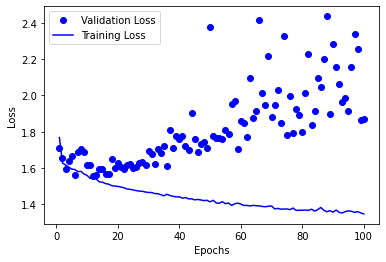

In [38]:
plt.plot(range(1, len(ave_val_loss_hist)+1)[:], ave_val_loss_hist[:], "bo", label="Validation Loss")
plt.plot(range(1, len(ave_val_loss_hist)+1)[:], ave_loss_hist[:], "b", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

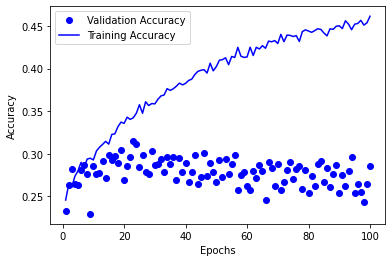

In [39]:
plt.plot(range(1, len(ave_val_acc_hist)+1)[:], ave_val_acc_hist[:], "bo", label="Validation Accuracy")
plt.plot(range(1, len(ave_val_acc_hist)+1)[:], ave_acc_hist[:], "b", label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Best Fit Model**

In [40]:
model=models.Sequential()
model.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2=.002), input_shape=(pic_size*pic_size,)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(5, activation="softmax"))
model.compile(optimizer="rmsprop", loss = "categorical_crossentropy", metrics=["accuracy"])

**Training the model with all samples**

In [41]:
model.fit(train_data,train_labels, epochs=10,verbose=1, batch_size=8)

Epoch 1/10
325/325 [==============================] - 2s 4ms/step - loss: 1.8686 - accuracy: 0.2186
Epoch 2/10
325/325 [==============================] - 1s 4ms/step - loss: 1.6562 - accuracy: 0.2606
Epoch 3/10
325/325 [==============================] - 1s 4ms/step - loss: 1.6138 - accuracy: 0.2692
Epoch 4/10
325/325 [==============================] - 1s 4ms/step - loss: 1.6078 - accuracy: 0.2826
Epoch 5/10
325/325 [==============================] - 1s 3ms/step - loss: 1.5887 - accuracy: 0.2945
Epoch 6/10
325/325 [==============================] - 1s 3ms/step - loss: 1.5690 - accuracy: 0.2904
Epoch 7/10
325/325 [==============================] - 1s 4ms/step - loss: 1.6107 - accuracy: 0.2783
Epoch 8/10
325/325 [==============================] - 1s 4ms/step - loss: 1.5737 - accuracy: 0.2798
Epoch 9/10
325/325 [==============================] - 1s 4ms/step - loss: 1.5580 - accuracy: 0.2998
Epoch 10/10
325/325 [==============================] - 1s 3ms/step - loss: 1.5597 - accuracy: 0.2967

**Evaluating the Model**

In [42]:
test_loss_score, test_acc_score=model.evaluate(test_data, test_labels)

54/54 [==============================] - 0s 2ms/step - loss: 1.5408 - accuracy: 0.3241


**Predicting the values**

In [43]:
prediction=model.predict(test_data)

In [44]:
prediction_result = []
for i, v in enumerate(prediction):
  prediction_result.append(np.argmax(prediction[i]))
print(prediction_result[:35])

test_labels_result = []
for i, v in enumerate(test_labels):
  test_labels_result.append(np.argmax(test_labels[i]))
print(test_labels_result[:35])

[1, 3, 3, 4, 1, 0, 4, 0, 4, 3, 3, 1, 4, 1, 4, 3, 1, 1, 1, 3, 1, 1, 4, 3, 1, 1, 4, 1, 4, 4, 4, 0, 4, 4, 4]
[1, 2, 0, 0, 0, 0, 4, 0, 2, 3, 3, 2, 3, 0, 3, 0, 2, 1, 4, 3, 2, 1, 4, 0, 1, 0, 4, 1, 0, 0, 2, 0, 1, 4, 2]


In [45]:
matched = []
for i, v in enumerate(test_labels_result):
  if  prediction_result[i] == test_labels_result[i]:
    matched.append("Yes")
  else:
    matched.append("No")

print("There are",matched.count("Yes"), "matched flowers and there are", matched.count("No"), "unmatched flowers ")

There are 560 matched flowers and there are 1168 unmatched flowers 
